In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import analyze_utils

cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

# Let's look at the results
These are the results for when we just query the model to ask it the relationship after few-shot prompting with a single example.

Load results

In [4]:
# dir_single_query = '/home/chansingh/mntv1/single_query_rough'
dir_single_query = '/home/chansingh/mntv1/single_query_math_9_12'
r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)


# dir_suffix_search = '/home/chansingh/mntv1/anli_rough' # note: anli_rought was missnamed
dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_12' # note: anli_rought was missnamed
r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

100%|██████████| 172/172 [00:13<00:00, 12.46it/s]


Index(['task_name', 'n_shots', 'max_dset_size', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'checkpoint',
       'max_num_tokens', 'beam_size', 'use_single_query', 'use_stopwords',
       'batch_size', 'seed', 'save_dir', 'use_cpu_only', 'use_parallelformers',
       'use_cache', 'use_verbose_saving', 'epoch_save_interval',
       'suffix_str_init', 'len_suffix_str_init', 'final_answer_full',
       'final_answer_added', 'final_model_queries',
       'final_num_suffixes_checked', 'final_answer_depth'],
      dtype='object')


100%|██████████| 133/133 [00:10<00:00, 12.66it/s]


Index(['task_name', 'n_shots', 'max_dset_size', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'checkpoint',
       'max_num_tokens', 'beam_size', 'use_single_query', 'use_stopwords',
       'batch_size', 'seed', 'save_dir', 'use_cpu_only', 'use_parallelformers',
       'use_cache', 'use_verbose_saving', 'epoch_save_interval',
       'suffix_str_init', 'len_suffix_str_init', 'final_answer_full',
       'final_answer_added', 'final_model_queries',
       'final_num_suffixes_checked', 'final_answer_depth'],
      dtype='object')


Plot relevant results

In [5]:
def num_suffixes_checked_tab(tab):
    return (tab
            # mean over templates, task_name)
            .groupby(['checkpoint', 'n_shots'])['final_num_suffixes_checked', 'use_single_query']
            .mean()
            .reset_index()
            )
tab_single_query = num_suffixes_checked_tab(r_single_query)
tab_suffix_search = num_suffixes_checked_tab(r_suffix_search)
tab = pd.concat((tab_single_query, tab_suffix_search)).sort_values('checkpoint')
tab['use_single_query'] = tab['use_single_query'].astype(bool)

/tmp/ipykernel_2964206/3726263579.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return (tab
/tmp/ipykernel_2964206/3726263579.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  return (tab


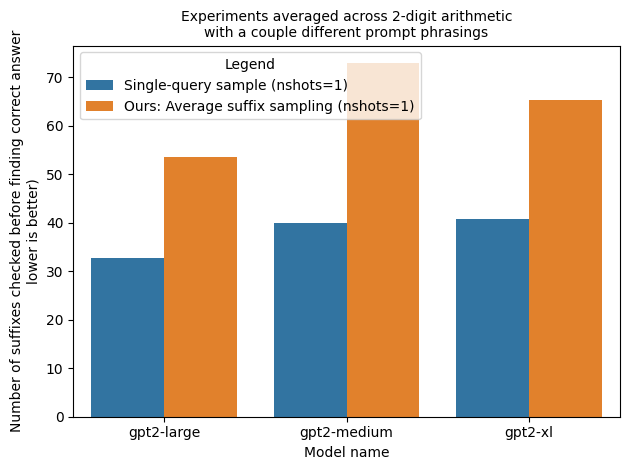

In [10]:
# reformat legend
VALS = {
    True: 'Single-query sample',
    False: 'Ours: Average suffix sampling',
}
tab['Legend'] = tab['use_single_query'].map(VALS) + ' (nshots=' + tab['n_shots'].astype(str) + ')'

# make plot
sns.barplot(x='checkpoint', y='final_num_suffixes_checked', hue='Legend', data=tab) #data=tab[tab['n_shots'] == 1])
plt.xlabel('Model name')
plt.ylabel('Number of suffixes checked before finding correct answer\nlower is better)')
plt.title('Experiments averaged across 2-digit arithmetic\nwith a couple different prompt phrasings', fontsize='medium')
plt.tight_layout()
plt.show()

# look at some of the tables

In [11]:
# cols_to_view = r_single_query.columns # cols_to_view
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]

In [12]:
r_single_query.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

,,final_model_queries,final_num_suffixes_checked,final_answer_depth,final_answer_found
checkpoint,n_shots,,,,
gpt2-large,1,1.39,32.65,1.37,1.0
gpt2-medium,1,1.62,40.02,1.41,1.0
gpt2-xl,1,1.46,40.77,1.40,1.0


In [13]:
r_single_query.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates

final_model_queries  \
checkpoint  n_shots task_name                           
gpt2-large  1       add_two                      1.00   
                    divide_two                   2.33   
                    multiply_two                 1.67   
gpt2-medium 1       add_two                      1.00   
                    divide_two                   5.50   
                    multiply_two                 1.67   
gpt2-xl     1       add_two                      1.07   
                    divide_two                   3.00   
                    multiply_two                 1.67   

                                  final_num_suffixes_checked  \
checkpoint  n_shots task_name                                  
gpt2-large  1       add_two                            15.70   
                    divide_two                        118.33   
                    multiply_two                       40.07   
gpt2-medium 1       add_two                            17.96   
                    divide_two                        164.25   
                    multiply_two                       43.67   
gpt2-xl     1       add_two                            26.81   
                    divide_two                        160.33   
                    multiply_two                       41.44   

                                  final_answer_depth  final_answer_found  
checkpoint  n_shots task_name                                             
gpt2-large  1       add_two                     1.00                 1.0  
                    divide_two                  2.00                 1.0  
                    multiply_two                1.67                 1.0  
gpt2-medium 1       add_two                     1.00                 1.0  
                    divide_two                  2.50                 1.0  
                    multiply_two                1.67                 1.0  
gpt2-xl     1       add_two                     1.07                 1.0  
                    divide_two                  2.00                 1.0  
                    multiply_two                1.67                 1.0

In [14]:
r_suffix_search.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

,,final_model_queries,final_num_suffixes_checked,final_answer_depth,final_answer_found
checkpoint,n_shots,,,,
gpt2-large,1,1.74,53.56,1.58,1.0
gpt2-medium,1,2.38,72.91,1.64,1.0
gpt2-xl,1,2.00,65.27,1.64,1.0


In [15]:
r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_model_queries  \
checkpoint  n_shots task_name                           
gpt2-large  1       add_two                      1.00   
                    divide_two                   2.78   
                    max_two                      1.57   
                    multiply_two                 1.67   
                    subtract_two                 1.67   
gpt2-medium 1       add_two                      1.00   
                    divide_two                   6.00   
                    first_two                    1.00   
                    max_two                      1.62   
                    multiply_two                 1.67   
                    subtract_two                 1.67   
gpt2-xl     1       add_two                      1.11   
                    divide_two                   3.89   
                    max_two                      1.67   
                    multiply_two                 1.67   
                    subtract_two                 1.67   

                                  final_num_suffixes_checked  \
checkpoint  n_shots task_name                                  
gpt2-large  1       add_two                            15.22   
                    divide_two                        114.22   
                    max_two                            46.86   
                    multiply_two                       40.00   
                    subtract_two                       50.00   
gpt2-medium 1       add_two                            18.89   
                    divide_two                        205.89   
                    first_two                           7.00   
                    max_two                            53.88   
                    multiply_two                       43.22   
                    subtract_two                       47.89   
gpt2-xl     1       add_two                            26.22   
                    divide_two                        149.78   
                    max_two                            51.89   
                    multiply_two                       41.67   
                    subtract_two                       56.78   

                                  final_answer_depth  final_answer_found  
checkpoint  n_shots task_name                                             
gpt2-large  1       add_two                     1.00                 1.0  
                    divide_two                  2.00                 1.0  
                    max_two                     1.57                 1.0  
                    multiply_two                1.67                 1.0  
                    subtract_two                1.67                 1.0  
gpt2-medium 1       add_two                     1.00                 1.0  
                    divide_two                  2.33                 1.0  
                    first_two                   1.00                 1.0  
                    max_two                     1.62                 1.0  
                    multiply_two                1.67                 1.0  
                    subtract_two                1.67                 1.0  
gpt2-xl     1       add_two                     1.11                 1.0  
                    divide_two                  2.11                 1.0  
                    max_two                     1.67                 1.0  
                    multiply_two                1.67                 1.0  
                    subtract_two                1.67                 1.0

In [9]:
rg = r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])
rg = rg[['final_model_queries','final_num_suffixes_checked']].mean().round(2) # mean over templates, task_name
print(rg.to_latex())

\begin{tabular}{lllrr}
\toprule
        &   &              &  final\_model\_queries &  final\_num\_suffixes\_checked \\
checkpoint & n\_shots & task\_name &                      &                             \\
\midrule
gpt2-large & 1 & add\_two &                 1.33 &                        5.67 \\
        &   & divide\_two &                 2.89 &                        8.67 \\
        &   & multiply\_two &                 3.89 &                       10.44 \\
gpt2-medium & 1 & add\_two &                 3.11 &                        8.44 \\
        &   & divide\_two &                 1.33 &                        5.44 \\
        &   & multiply\_two &                 1.33 &                        4.78 \\
gpt2-xl & 1 & add\_two &                 2.33 &                       12.11 \\
        &   & divide\_two &                 5.11 &                       18.78 \\
        &   & multiply\_two &                 1.33 &                        6.78 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2765084/1313215481.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rg.to_latex())


# look at individual results

In [ ]:
results_dir = '/home/chansingh/mntv1/sweep0/Sep_02_21_24_zjpbgvrtlohx'
r = pkl.load(open(oj(results_dir, 'results_final.pkl'), 'rb'))
print(r)